In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import librosa
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import os
import h5py

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Load embeddings and align classes

In [3]:
embeddings = h5py.File('embeddings.h5', 'r')

def printname(name):
    print(name)
embeddings.visit(printname)

irmas
irmas/openl3
irmas/openl3/features
irmas/openl3/keys
irmas/vggish
irmas/vggish/features
irmas/vggish/keys
openmic
openmic/openl3
openmic/openl3/features
openmic/openl3/keys
openmic/vggish
openmic/vggish/features
openmic/vggish/keys


In [4]:
with open('class-map-10.json', 'r') as f:
    class_map = json.load(f)
    
class_map

{'cello': 3,
 'clarinet': 4,
 'flute': 7,
 'guitar': 8,
 'organ': 11,
 'piano': 12,
 'saxophone': 13,
 'trumpet': 16,
 'violin': 18,
 'voice': 19}

In [5]:
class_align = {'cello': 'cel',
               'clarinet': 'cla',
               'flute': 'flu',
               'guitar': ['gac', 'gel'],
               'organ': 'org',
               'piano': 'pia',
               'saxophone': 'sax',
               'trumpet': 'tru',
               'violin': 'vio',
               'voice': 'voi'}

# irmas->irmas

In [6]:
# irmas: Vggish embedding
feature = np.array(embeddings['irmas']['vggish']['features'])
keys_ori = np.array(embeddings['irmas']['vggish']['keys'])
print(feature.shape, keys_ori.shape)

key_clip = np.unique(keys_ori)
print(key_clip.shape)

(13410, 128) (13410,)
(6705,)


In [7]:
key_clip

array([b'001__[gel][dru][pop_roc]0829__1',
       b'001__[gel][dru][pop_roc]0829__2',
       b'001__[gel][dru][pop_roc]0829__3', ..., b'[voi][pop_roc]2548__1',
       b'[voi][pop_roc]2548__2', b'[voi][pop_roc]2548__3'], dtype=object)

In [8]:
feature_clip = []

for key in tqdm(key_clip):
    feature_clip.append(np.mean(feature[keys_ori[:]==key,:],axis=0))
    
feature_clip = np.array(feature_clip)
print(feature_clip.shape, key_clip.shape)

/import/research_c4dm/cw304/anaconda3/envs/kymatio_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/6705 [00:00<?, ?it/s]

(6705, 128) (6705,)


In [9]:
key_train = list(pd.read_csv('irmas_train.csv', header=None, squeeze=True))
key_test = list(pd.read_csv('irmas_test.csv', header=None, squeeze=True))

In [10]:
# these loops go through all sample keys, and save their row numbers to either idx_train or idx_test
idx_train, idx_test = [], []

for k in range(len(key_clip)):
    if str(key_clip[k]) in key_train:
        idx_train.append(k)
    elif str(key_clip[k]) in key_test:
        idx_test.append(k)
    else:
        # This should never happen, but better safe than sorry.
        raise RuntimeError('Unknown sample key={}! Abort!'.format(key_clip[k]))
        
# cast the idx_* arrays to numpy structures
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [11]:
keys = np.array([str(k, 'utf-8') for k in key_clip])
keys = [key[key.index('[')+1:key.index(']')] for key in keys]

for key in class_align:
    keys = [key if x in class_align[key] else x for x in keys]
    
keys = np.array(keys)
np.unique(keys)

array(['cello', 'clarinet', 'flute', 'guitar', 'organ', 'piano',
       'saxophone', 'trumpet', 'violin', 'voice'], dtype='<U9')

In [12]:
# use the split indices to partition the features, labels, and masks
X_train = feature_clip[idx_train,:]
X_test = feature_clip[idx_test]

Y_true_train = keys[idx_train]
Y_true_test = keys[idx_test]

# print out the sliced shapes as a sanity check
print(X_train.shape)
print(X_test.shape)

(3910, 128)
(2795, 128)


In [13]:
# use a dictionary to include the classifier for each instrument trained on IRMAS dataset based on Vggish embedding
models_vggish_irmas = dict()  
# use a dictionary to record the classification result for each instrument
result_vggish_irmas_irmas = dict()  

# iterate over all istrument classes, and fit a model for each one
for instrument in class_align:
    
    # get the training and testing labels for each instrument
    Y_true_train_inst = Y_true_train==instrument
    Y_true_test_inst = Y_true_test==instrument
    
    # initialize and fit a logistic regression model
    clf = LogisticRegression(random_state=0, penalty='l1', solver='liblinear')
    clf.fit(X_train, Y_true_train_inst)

    # predict
    Y_pred_test = clf.predict(X_test)
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test))
    
    # Store the classifier in the model dictionary
    models_vggish_irmas[instrument] = clf
    
    #########################  record result of each split  ###############################
    # extract P,R,F values from classification_report
    lineSep = 54 ; dist = 10; 
    Pos_firstNum = classification_report(Y_true_test_inst, Y_pred_test).find('\n') + 21 
    result_vggish_irmas_irmas[instrument] = np.array([float(classification_report(Y_true_test_inst, Y_pred_test)[Pos_firstNum+lineSep:Pos_firstNum+4+lineSep]),\
              float(classification_report(Y_true_test_inst, Y_pred_test)[Pos_firstNum+dist*1+lineSep:Pos_firstNum+4+dist*1+lineSep]),\
              float(classification_report(Y_true_test_inst, Y_pred_test)[Pos_firstNum+dist*2+lineSep:Pos_firstNum+4+dist*2+lineSep])])

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.99      0.98      0.99      2765
        True       0.25      0.50      0.33        30

    accuracy                           0.98      2795
   macro avg       0.62      0.74      0.66      2795
weighted avg       0.99      0.98      0.98      2795

----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       1.00      0.85      0.92      2744
        True       0.09      0.80      0.16        51

    accuracy                           0.85      2795
   macro avg       0.54      0.83      0.54      2795
weighted avg       0.98      0.85      0.90      2795

----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.88      0.98      0.93      2388
        True       0.64      0.20      

In [14]:
result_vggish_irmas_irmas

{'cello': array([0.25, 0.5 , 0.33]),
 'clarinet': array([0.09, 0.8 , 0.16]),
 'flute': array([0.64, 0.2 , 0.31]),
 'guitar': array([0.64, 0.6 , 0.62]),
 'organ': array([0.02, 1.  , 0.03]),
 'piano': array([0.88, 0.45, 0.6 ]),
 'saxophone': array([0.6 , 0.24, 0.34]),
 'trumpet': array([0.75, 0.27, 0.4 ]),
 'violin': array([0.24, 0.58, 0.34]),
 'voice': array([0.67, 0.92, 0.77])}

In [15]:
# result averaged over all instruments
PRF_vggish_irmas_irmas = []
for instrument in class_map:
    PRF_vggish_irmas_irmas.append(result_vggish_irmas_irmas[instrument])
PRF_vggish_irmas_irmas = np.array(PRF_vggish_irmas_irmas)
np.mean(PRF_vggish_irmas_irmas,axis=0)

array([0.478, 0.556, 0.39 ])

# openmic->openmic

In [16]:
# openmic: vggish embedding
feature = np.array(embeddings['openmic']['vggish']['features'])
keys = np.array(embeddings['openmic']['vggish']['keys'])
print(feature.shape, keys.shape)

key_clip = np.unique(keys)
key_clip.shape

(180000, 128) (180000,)


(20000,)

In [17]:
feature_clip = []

for key in tqdm(key_clip):
    feature_clip.append(np.mean(feature[keys[:]==key,:],axis=0))
    
feature_clip = np.array(feature_clip)
print(feature_clip.shape, key_clip.shape)

key_clip = np.array([str(k, 'utf-8') for k in key_clip])
key_clip

/import/research_c4dm/cw304/anaconda3/envs/kymatio_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/20000 [00:00<?, ?it/s]

(20000, 128) (20000,)


array(['000046_3840', '000135_483840', '000139_119040', ...,
       '155307_211200', '155310_372480', '155311_453120'], dtype='<U15')

In [18]:
# key-label map using the information from the dataset source
data_root = '/import/c4dm-datasets/openmic-2018/openmic-2018/'

np_load_old = np.load   # save np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True,**k)   # modify the default parameters of np.load

Ytrue = np.load(os.path.join(data_root, 'openmic-2018.npz'))['Y_true']
Ymask = np.load(os.path.join(data_root, 'openmic-2018.npz'))['Y_mask']
sample_key = np.load(os.path.join(data_root, 'openmic-2018.npz'))['sample_key']

np.load = np_load_old   # restore np.load for future normal usage
del(np_load_old)

print(Ytrue.shape, Ymask.shape, sample_key.shape)

(20000, 20) (20000, 20) (20000,)


In [19]:
Y_true = []
Y_mask = []

for key in tqdm(key_clip):
    Y_true.append(Ytrue[sample_key==key])
    Y_mask.append(Ymask[sample_key==key])
    
Y_true = np.squeeze(np.array(Y_true))
Y_mask = np.squeeze(np.array(Y_mask))

X = feature_clip
del(feature_clip)

print(X.shape, Y_true.shape, Y_mask.shape)

/import/research_c4dm/cw304/anaconda3/envs/kymatio_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/20000 [00:00<?, ?it/s]

(20000, 128) (20000, 20) (20000, 20)


In [20]:
# train-test split
split_train = pd.read_csv('openmic2018_train.csv', header=None, squeeze=True)
split_test = pd.read_csv('openmic2018_test.csv', header=None, squeeze=True)

print('# Train: {},  # Test: {}'.format(len(split_train), len(split_test)))

train_set = set(split_train)
test_set = set(split_test)

# Train: 14915,  # Test: 5085


In [21]:
idx_train, idx_test = [], []

for idx, n in enumerate(key_clip):
    if n in train_set:
        idx_train.append(idx)
    elif n in test_set:
        idx_test.append(idx)
    else:
        raise RuntimeError('Unknown sample key={}! Abort!'.format(key_clip[n]))
        
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [22]:
X_train = X[idx_train]
X_test = X[idx_test]

Y_true_train = Y_true[idx_train]
Y_true_test = Y_true[idx_test]

Y_mask_train = Y_mask[idx_train]
Y_mask_test = Y_mask[idx_test]

print(X_train.shape); print(X_test.shape)

(14915, 128)
(5085, 128)


In [23]:
# This part of the code follows the baseline model for instrument recognition on the openmic dataset:
# https://github.com/cosmir/openmic-2018/blob/master/examples/modeling-baseline.ipynb
# use a dictionary to include the classifier for each instrument trained on Openmic dataset based on Vggish embedding
models_vggish_openmic = dict()  
# use a dictionary to record the classification result for each instrument
result_vggish_openmic_openmic = dict()  

# We'll iterate over all istrument classes, and fit a model for each one
# After training, we'll print a classification report for each instrument
for instrument in class_map:
    
    # Map the instrument name to its column number
    inst_num = class_map[instrument]
    
    # First, sub-sample the data: we need to select down to the data for which we have annotations
    # This is what the mask arrays are for
    train_inst = Y_mask_train[:, inst_num]
    test_inst = Y_mask_test[:, inst_num]
    
    # Here, we're using the Y_mask_train array to slice out only the training examples
    # for which we have annotations for the given class
    X_train_inst = X_train[train_inst]
    
    # Again, we slice the labels to the annotated examples
    # We thresold the label likelihoods at 0.5 to get binary labels
    Y_true_train_inst = Y_true_train[train_inst, inst_num] >= 0.5
    
    # Repeat the above slicing and dicing but for the test set
    X_test_inst = X_test[test_inst]
    Y_true_test_inst = Y_true_test[test_inst, inst_num] >= 0.5

    # initialize and fit a logistic regression model
    clf = LogisticRegression(random_state=0, penalty='l1', solver='liblinear')
    clf.fit(X_train_inst, Y_true_train_inst)

    # predict
    Y_pred_test = clf.predict(X_test_inst)
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test))
    
    # Store the classifier in the model dictionary
    models_vggish_openmic[instrument] = clf
    
    #########################  record result of each split  ###############################
    # extract P,R,F values from classification_report
    lineSep = 54 ; dist = 10; 
    Pos_firstNum = classification_report(Y_true_test_inst, Y_pred_test).find('\n') + 21 
    result_vggish_openmic_openmic[instrument] = np.array([float(classification_report(Y_true_test_inst, Y_pred_test)[Pos_firstNum+lineSep:Pos_firstNum+4+lineSep]),\
              float(classification_report(Y_true_test_inst, Y_pred_test)[Pos_firstNum+dist*1+lineSep:Pos_firstNum+4+dist*1+lineSep]),\
              float(classification_report(Y_true_test_inst, Y_pred_test)[Pos_firstNum+dist*2+lineSep:Pos_firstNum+4+dist*2+lineSep])])

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.77      0.79      0.78       259
        True       0.75      0.73      0.74       226

    accuracy                           0.76       485
   macro avg       0.76      0.76      0.76       485
weighted avg       0.76      0.76      0.76       485

----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.83      0.89      0.86       503
        True       0.47      0.35      0.40       137

    accuracy                           0.78       640
   macro avg       0.65      0.62      0.63       640
weighted avg       0.76      0.78      0.76       640

----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.81      0.84      0.83       387
        True       0.62      0.57      

In [24]:
result_vggish_openmic_openmic

{'cello': array([0.75, 0.73, 0.74]),
 'clarinet': array([0.47, 0.35, 0.4 ]),
 'flute': array([0.62, 0.57, 0.59]),
 'guitar': array([0.92, 0.96, 0.94]),
 'organ': array([0.58, 0.4 , 0.48]),
 'piano': array([0.92, 0.96, 0.94]),
 'saxophone': array([0.8 , 0.82, 0.81]),
 'trumpet': array([0.76, 0.7 , 0.73]),
 'violin': array([0.87, 0.85, 0.86]),
 'voice': array([0.92, 0.92, 0.92])}

In [25]:
# result averaged over all instruments
PRF_vggish_openmic_openmic = []
for instrument in class_map:
    PRF_vggish_openmic_openmic.append(result_vggish_openmic_openmic[instrument])
PRF_vggish_openmic_openmic = np.array(PRF_vggish_openmic_openmic)
np.mean(PRF_vggish_openmic_openmic,axis=0)

array([0.761, 0.726, 0.741])

# irmas->openmic

In [26]:
# use a dictionary to record the classification result for each instrument
result_vggish_irmas_openmic = dict()  

# iterate over all istrument classes, and fit a model for each one
for instrument in class_align:
    
    # Map the instrument name to its column number
    inst_num = class_map[instrument]
    
    # First, sub-sample the data: we need to select down to the data for which we have annotations 
    # This is what the mask arrays are for
    test_inst = Y_mask_test[:, inst_num]

    # Repeat the above slicing and dicing but for the test set
    X_test_inst = X_test[test_inst]
    Y_true_test_inst = Y_true_test[test_inst, inst_num] >= 0.5

    # Finally, we'll evaluate the classifier trained on IRMAS dataset to the Openmic test data
    Y_pred_test =  models_vggish_irmas[instrument].predict(X_test_inst)
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test))
    
    #########################  record result for each instrument  ###############################
    # extract P,R,F values from classification_report
    lineSep = 54 ; dist = 10; 
    Pos_firstNum = classification_report(Y_true_test_inst, Y_pred_test).find('\n') + 21 
    result_vggish_irmas_openmic[instrument] = np.array([float(classification_report(Y_true_test_inst, Y_pred_test)[Pos_firstNum+lineSep:Pos_firstNum+4+lineSep]),\
              float(classification_report(Y_true_test_inst, Y_pred_test)[Pos_firstNum+dist*1+lineSep:Pos_firstNum+4+dist*1+lineSep]),\
              float(classification_report(Y_true_test_inst, Y_pred_test)[Pos_firstNum+dist*2+lineSep:Pos_firstNum+4+dist*2+lineSep])])

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.56      0.88      0.69       259
        True       0.62      0.22      0.32       226

    accuracy                           0.57       485
   macro avg       0.59      0.55      0.51       485
weighted avg       0.59      0.57      0.52       485

----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.82      0.87      0.85       503
        True       0.40      0.31      0.35       137

    accuracy                           0.75       640
   macro avg       0.61      0.59      0.60       640
weighted avg       0.73      0.75      0.74       640

----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.69      0.96      0.81       387
        True       0.44      0.06      

In [27]:
result_vggish_irmas_openmic

{'cello': array([0.62, 0.22, 0.32]),
 'clarinet': array([0.4 , 0.31, 0.35]),
 'flute': array([0.44, 0.06, 0.11]),
 'guitar': array([0.96, 0.71, 0.82]),
 'organ': array([0.4 , 0.53, 0.46]),
 'piano': array([0.99, 0.55, 0.7 ]),
 'saxophone': array([0.89, 0.03, 0.05]),
 'trumpet': array([1.  , 0.03, 0.06]),
 'violin': array([0.92, 0.36, 0.52]),
 'voice': array([0.98, 0.77, 0.86])}

In [28]:
# result averaged over all instruments
PRF_vggish_irmas_openmic = []
for instrument in class_map:
    PRF_vggish_irmas_openmic.append(result_vggish_irmas_openmic[instrument])
PRF_vggish_irmas_openmic = np.array(PRF_vggish_irmas_openmic)
np.mean(PRF_vggish_irmas_openmic,axis=0)

array([0.76 , 0.357, 0.425])

# openmic->irmas

In [29]:
# irmas: vggish embedding
feature = np.array(embeddings['irmas']['vggish']['features'])
keys_ori = np.array(embeddings['irmas']['vggish']['keys'])
print(feature.shape, keys_ori.shape)

key_clip = np.unique(keys_ori)
print(key_clip.shape)

feature_clip = []

for key in tqdm(key_clip):
    feature_clip.append(np.mean(feature[keys_ori[:]==key,:],axis=0))
    
feature_clip = np.array(feature_clip)
print(feature_clip.shape, key_clip.shape)

(13410, 128) (13410,)
(6705,)


/import/research_c4dm/cw304/anaconda3/envs/kymatio_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/6705 [00:00<?, ?it/s]

(6705, 128) (6705,)


In [30]:
key_train = list(pd.read_csv('irmas_train.csv', header=None, squeeze=True))
key_test = list(pd.read_csv('irmas_test.csv', header=None, squeeze=True))

idx_train, idx_test = [], []

for k in range(len(key_clip)):
    if str(key_clip[k]) in key_train:
        idx_train.append(k)
    elif str(key_clip[k]) in key_test:
        idx_test.append(k)
    else:
        raise RuntimeError('Unknown sample key={}! Abort!'.format(key_clip[k]))
        
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [31]:
keys = np.array([str(k, 'utf-8') for k in key_clip])
keys = [key[key.index('[')+1:key.index(']')] for key in keys]

for key in class_align:
    keys = [key if x in class_align[key] else x for x in keys]
    
keys = np.array(keys)
np.unique(keys)

array(['cello', 'clarinet', 'flute', 'guitar', 'organ', 'piano',
       'saxophone', 'trumpet', 'violin', 'voice'], dtype='<U9')

In [32]:
X_train = feature_clip[idx_train,:]
X_test = feature_clip[idx_test]

Y_true_train = keys[idx_train]
Y_true_test = keys[idx_test]

print(X_train.shape)
print(X_test.shape)

(3910, 128)
(2795, 128)


In [33]:
# use a dictionary to record the classification result for each instrument
result_vggish_openmic_irmas = dict()  

# iterate over all istrument classes, and fit a model for each one
for instrument in class_align:
    
    # get the training and testing labels for each instrument
    Y_true_test_inst = Y_true_test==instrument

    # Finally, we'll evaluate the classifier trained on IRMAS dataset to the Openmic test data
    Y_pred_test =  models_vggish_openmic[instrument].predict(X_test)
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test))
    
    #########################  record result for each instrument  ###############################
    # extract P,R,F values from classification_report
    lineSep = 54 ; dist = 10; 
    Pos_firstNum = classification_report(Y_true_test_inst, Y_pred_test).find('\n') + 21 
    result_vggish_openmic_irmas[instrument] = np.array([float(classification_report(Y_true_test_inst, Y_pred_test)[Pos_firstNum+lineSep:Pos_firstNum+4+lineSep]),\
              float(classification_report(Y_true_test_inst, Y_pred_test)[Pos_firstNum+dist*1+lineSep:Pos_firstNum+4+dist*1+lineSep]),\
              float(classification_report(Y_true_test_inst, Y_pred_test)[Pos_firstNum+dist*2+lineSep:Pos_firstNum+4+dist*2+lineSep])])

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       1.00      0.72      0.84      2765
        True       0.03      0.87      0.06        30

    accuracy                           0.73      2795
   macro avg       0.52      0.80      0.45      2795
weighted avg       0.99      0.73      0.83      2795

----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.99      0.80      0.88      2744
        True       0.06      0.65      0.10        51

    accuracy                           0.80      2795
   macro avg       0.52      0.72      0.49      2795
weighted avg       0.97      0.80      0.87      2795

----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.92      0.60      0.73      2388
        True       0.23      0.71      

In [34]:
result_vggish_openmic_irmas

{'cello': array([0.03, 0.87, 0.06]),
 'clarinet': array([0.06, 0.65, 0.1 ]),
 'flute': array([0.23, 0.71, 0.35]),
 'guitar': array([0.28, 0.76, 0.41]),
 'organ': array([0., 0., 0.]),
 'piano': array([0.34, 0.83, 0.48]),
 'saxophone': array([0.3 , 0.79, 0.44]),
 'trumpet': array([0.41, 0.81, 0.55]),
 'violin': array([0.06, 0.91, 0.1 ]),
 'voice': array([0.16, 0.98, 0.27])}

In [35]:
# result averaged over all instruments
PRF_vggish_openmic_irmas = []
for instrument in class_map:
    PRF_vggish_openmic_irmas.append(result_vggish_openmic_irmas[instrument])
PRF_vggish_openmic_irmas = np.array(PRF_vggish_openmic_irmas)
np.mean(PRF_vggish_openmic_irmas,axis=0)

array([0.187, 0.731, 0.276])

# Plot result on each instrument

In [36]:
# The mean PRF for each case:
print('PRF of Vggish averaged over all instruments for each case:')
print('irmas->irmas:{}'.format(np.mean(PRF_vggish_irmas_irmas,axis=0)))
print('openmic->openmic:{}'.format(np.mean(PRF_vggish_openmic_openmic,axis=0)))
print('irmas->openmic:{}'.format(np.mean(PRF_vggish_irmas_openmic,axis=0)))
print('openmic->irmas:{}'.format(np.mean(PRF_vggish_openmic_irmas,axis=0)))

PRF of Vggish averaged over all instruments for each case:
irmas->irmas:[0.478 0.556 0.39 ]
openmic->openmic:[0.761 0.726 0.741]
irmas->openmic:[0.76  0.357 0.425]
openmic->irmas:[0.187 0.731 0.276]


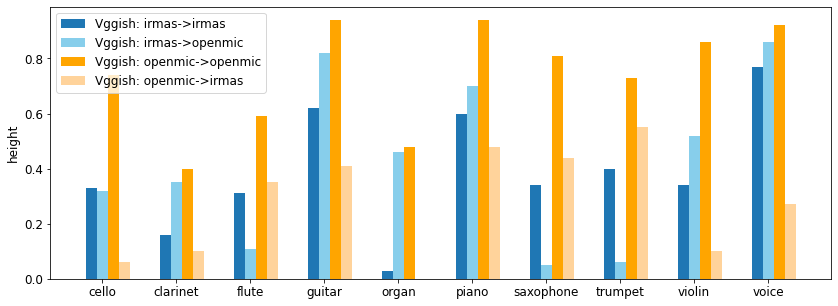

In [37]:
plt.rcParams.update({'font.size':12})
plt.figure(figsize=(14,5))
 
barWidth = 0.15  # width of the bars

# Set bars
bars1 = [result_vggish_irmas_irmas[inst][-1] for inst in class_align]
bars2 = [result_vggish_irmas_openmic[inst][-1] for inst in class_align]
bars3 = [result_vggish_openmic_openmic[inst][-1] for inst in class_align]
bars4 = [result_vggish_openmic_irmas[inst][-1] for inst in class_align]

# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]
r4 = [x + 3*barWidth for x in r1]
 
# Create bars
plt.bar(r1, bars1, width = barWidth, capsize=7, label='Vggish: irmas->irmas')
plt.bar(r2, bars2, width = barWidth, color='skyblue', capsize=7, label='Vggish: irmas->openmic')
plt.bar(r3, bars3, width = barWidth, color='#FFA500', capsize=7, label='Vggish: openmic->openmic')
plt.bar(r4, bars4, width = barWidth, color='#FFD39B', capsize=7, label='Vggish: openmic->irmas')
 
plt.xticks([r + barWidth for r in range(len(bars1))], [inst for inst in class_align])
plt.ylabel('height'); plt.legend()